In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import wandb
import random
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
wandb.login()

wandb: Currently logged in as: anmolmunnolli. Use `wandb login --relogin` to force relogin


True

In [4]:
train_dir = "/car-damage/data1a/training"
validation_dir = "/car-damage/data1a/validation"

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

Found 1840 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


In [7]:
run = wandb.init(
    project="mlops_Safar",
    config={
        "layer_1":256,
        "activation":"relu",
        "dropout":random.uniform(0.01,0.75),
        "layer_2":512,
        "optimizer":"adam",
        "loss":"binary_crossentropy",
        "metric":"accuracy",
        "output":"sigmoid",
        "epoch":5,
        "batch_size":64
    })

In [8]:
config = wandb.config

In [9]:
from tensorflow.keras import Model
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(input_shape = (224, 224, 3),  include_top = False, weights = 'imagenet')

x = tf.keras.layers.Flatten()(base_model.output)
x = tf.keras.layers.Dense(config.layer_1, activation=config.activation)(x)
x = tf.keras.layers.Dropout(config.dropout)(x)
x = tf.keras.layers.Dense(config.layer_2,activation=config.activation)(x)
x = tf.keras.layers.Dropout(config.dropout)(x)
x = tf.keras.layers.Dense(1, activation=config.output)(x)

model= Model(base_model.input, x)

94765736/94765736 [==============================] - 1s 0us/step


In [10]:
model.compile(optimizer=config.optimizer,loss=config.loss,metrics=[config.metric])

In [11]:
callback = [WandbMetricsLogger(log_freq=5),
            WandbModelCheckpoint("models")
           ]
history = model.fit(
      train_generator,
      epochs=config.epoch,
      batch_size=config.batch_size,
      validation_data=validation_generator,
      callbacks=callback)

Epoch 1/5
92/92 [==============================] - ETA: 0s - loss: 1.6074 - accuracy: 0.6288

wandb: Adding directory to artifact (./models)... Done. 2.3s


92/92 [==============================] - 97s 549ms/step - loss: 1.6074 - accuracy: 0.6288 - val_loss: 2.5076 - val_accuracy: 0.5000
Epoch 2/5
92/92 [==============================] - ETA: 0s - loss: 0.7487 - accuracy: 0.6995

wandb: Adding directory to artifact (./models)... Done. 2.5s


92/92 [==============================] - 45s 494ms/step - loss: 0.7487 - accuracy: 0.6995 - val_loss: 0.7436 - val_accuracy: 0.5043
Epoch 3/5
92/92 [==============================] - ETA: 0s - loss: 0.5229 - accuracy: 0.7674

wandb: Adding directory to artifact (./models)... Done. 2.4s


92/92 [==============================] - 47s 512ms/step - loss: 0.5229 - accuracy: 0.7674 - val_loss: 0.7182 - val_accuracy: 0.5000
Epoch 4/5
92/92 [==============================] - ETA: 0s - loss: 0.4658 - accuracy: 0.8168

wandb: Adding directory to artifact (./models)... Done. 2.3s


92/92 [==============================] - 48s 521ms/step - loss: 0.4658 - accuracy: 0.8168 - val_loss: 0.6943 - val_accuracy: 0.5000
Epoch 5/5
92/92 [==============================] - ETA: 0s - loss: 0.4610 - accuracy: 0.8266

wandb: Adding directory to artifact (./models)... Done. 2.3s


92/92 [==============================] - 48s 521ms/step - loss: 0.4610 - accuracy: 0.8266 - val_loss: 1.0090 - val_accuracy: 0.5000


In [12]:
model.save("classifier.h5")

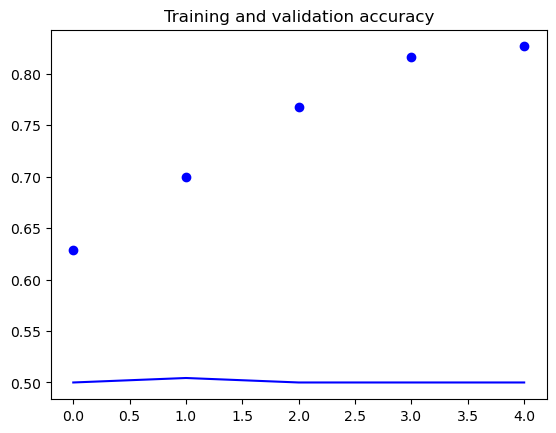

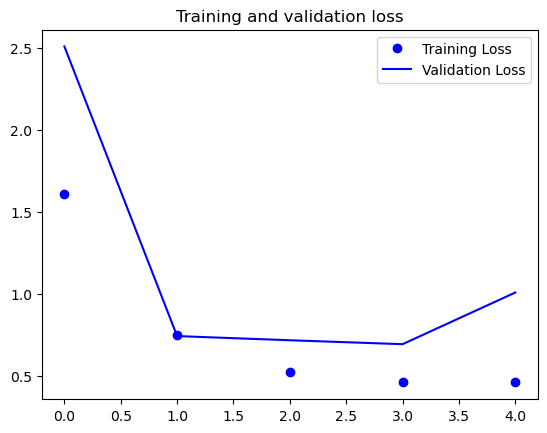

In [13]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()